# Create mask (inc vs dec) based on ML HYCOM data, classify data in increasing vs decreasing, calculate composites and make maps


In [1]:
import xarray as xr
import csv
import pandas as pd
import pickle
import numpy as np
import os
from datetime import date, timedelta, datetime
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import netCDF4 as nc4
import glob
import os.path
import webbrowser
import time
import gsw
import scipy.io as scipy
# from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import matplotlib as mpl
from FUNCTIONS_HYCOM import set_regions, set_regions_tags, find_timedelta64_index, \
create_composite, name_composite, below_above_MLD, plot_simple_pcolor, set_regions_offset, draw_box, \
save_3dvars_as_nc4, save_2dvars_as_nc4, save_1dvars_as_nc4, \
set_cmap, set_clim_plots, set_clim_plots_std, set_clim_plots_diff, set_clim_plots_std_diff, \
function_map_2D_hist, function_plots, function_single_panels_plots, function_single_panels_plots_grey_shading
import pickle as pkl
from holteandtalley import HolteAndTalley
import subprocess
import numpy.matlib

In [2]:
# Open netcdf with both HYCOM and forcing data from all events across all regions, at hourly resolution
combined_regions = xr.open_dataset('/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/scripf_for_downloading_forcing_files_CURC/combined_regions_with_rel_hum.nc4')
# combined_regions.depth

In [3]:
# Specify the new depth levels with a step of 5
new_depth_levels = np.arange(0, 510, 5)

# Interpolate along the 'depth' dimension using linear interpolation
combined_regions_interpolated = combined_regions.interp(depth = new_depth_levels, method='linear')


In [4]:
# REMOVE i_time if it's the same as index_time_start 
i_time = int((np.abs(combined_regions.delta_time - int(-2 * 24 * 60 * 60 * 1E9))).argmin()) # time index where to perform the classification (-2 days)

# Needed for composite calculation & plots
index_time_start = int((np.abs(combined_regions.delta_time - int(-2 * 24 * 60 * 60 * 1E9))).argmin()) # 2 days prior
index_time_end = int((np.abs(combined_regions.delta_time - int(14 * 24 * 60 * 60 * 1E9))).argmin()) # 14 days after
index_time_end_10days = int((np.abs(combined_regions.delta_time - int(10 * 24 * 60 * 60 * 1E9))).argmin()) # 14 days after

# Needed for composite plots
offset_lon = 20
timesteps_before = 2*24 # 2 days prior
timesteps_after = 14*24 # 14 days after
time_plot = np.arange(-timesteps_before,timesteps_after+1,1) * 1/24


In [5]:
# Inputs to decide which incr/decr mask to use
ML_delta = 50 # 1/2 1/3 2/3 1 10 20 30 40 50 60 70 
mode_tag = 'absolute' # 'fraction' # 'absolute'
mask_tag = 'plus50m' # 1ML halfML 1thirdML 2thirdML plus10m plus20m plus30m plus40m plus50m plus60m plus70m

diagonal_plot_tag = False
sanity_check_plot_tag = False

In [6]:
# RUN DONE 
# 2/3 1/3 1/2 1 10m 20m 30m 40m 50m 60m 
#10m 20m 30m 40m 50m 60m 70m

# grey shading
# 10, 20, 30, 40, 50, 60, 70m
# 1ML

In [7]:
# Vertical structure of absolute salinity, to use for classification
data = combined_regions_interpolated.salinity_abs

# MLD to use for classification
MLD = combined_regions_interpolated.salinityMLD_abs

In [8]:
def HYCOM_inc_dec_masks(data, MLD, ML_delta, mode_tag):
    # Initialize lists for masks
    mask_incr = []
    mask_decr = []

    for i_event in np.arange(data.shape[0]):  # loop across events

        # MIXED LAYER
        # Find depth index to insert ML
        i_depth_MLD = np.searchsorted(data[i_event].depth.values, MLD[i_event][i_time])
        # Create new depth axis which includes MLD
        depth_MLD = np.insert(data[i_event].depth.values, i_depth_MLD, MLD[i_event][i_time])
        # Calculate salinity at MLD via interpolation
        salinity_abs_upper = data[i_event][i_time].interp(depth=depth_MLD)

        # Calculate weighted average of salinity within the ML (from surface to MLD)
        # First, need to calculate dz (depth of each layer associated with a salinity value)
        depth_MLD_upper = np.insert(depth_MLD, i_depth_MLD, MLD[i_event][i_time])  # add another MLD value next to the other one
        depth_MLD_upper = np.insert(depth_MLD_upper, 0, 0)  # add another zero at the beginning of the depth

        dz = (depth_MLD_upper[2:i_depth_MLD+3] - depth_MLD_upper[0:i_depth_MLD+1]) / 2  # calculate dz as half of the difference between depth value above and below each depth
        MLS_abs_wgt = (np.sum(dz * salinity_abs_upper[0:i_depth_MLD+1])) / np.sum(dz)  # weighted average from surface to MLD

        # LAYER BELOW ML
        # Calculate bottom limit of layer to consider
        if mode_tag == 'fraction': # e.g., MLD + one third of it
            bottom_limit = MLD[i_event][i_time] + MLD[i_event][i_time] * ML_delta
        elif mode_tag == 'absolute': # e.g., 10 m below MLD
            bottom_limit = MLD[i_event][i_time] + ML_delta   
        # Add another MLD value next to the other one
        depth_below_ML = np.insert(depth_MLD, i_depth_MLD, MLD[i_event][i_time])  # add another MLD value next to the other one
        # Find index of bottom limit
        i_depth_meters_below_MLD = np.searchsorted(depth_below_ML, bottom_limit)
        # Create new depth axis which includes bottom_limit
        depth_below_ML = np.insert(depth_below_ML, i_depth_meters_below_MLD, bottom_limit)  # add bottom_limit
        depth_below_ML = np.insert(depth_below_ML, i_depth_meters_below_MLD, bottom_limit)  # add bottom_limit

        # Calculate salinity at bottom_limit via interpolation
        salinity_abs_lower = data[i_event][i_time].interp(depth=depth_below_ML)

        dz = (depth_below_ML[i_depth_MLD+2:i_depth_meters_below_MLD+2] - depth_below_ML[i_depth_MLD:i_depth_meters_below_MLD])/2  # calculate dz as half of the difference between depth value above and below each depth
        salinity_abs_wgt_lower = (np.sum(dz * salinity_abs_lower[i_depth_MLD+1:i_depth_meters_below_MLD+1])) / np.sum(dz)  # weighted average from MLD to bottom_limit

        # Calculate difference between salinity in layer below ML and weighted average of salinity in the ML
#         mean_salinity_diff_below = np.mean(salinity_abs_wgt_lower - MLS_abs_wgt)
        mean_salinity_diff_below = salinity_abs_wgt_lower - MLS_abs_wgt
#         print(salinity_abs_wgt_lower)
#         print('_________')
#         print(mean_salinity_diff_below)
#         print('_________')
#         print(MLS_abs_wgt)
        # If mean_salinity_diff_below > 0 --> increasing
        if mean_salinity_diff_below > 0: 
            mask_incr.append(1)
            mask_decr.append(0)
        # If mean_salinity_diff_below < 0 --> decreasing
        elif mean_salinity_diff_below < 0: 
            mask_incr.append(0)
            mask_decr.append(1)
        else:  # Nans or other weird stuff
            mask_incr.append(0)
            mask_decr.append(0)
            
    return(mask_incr, mask_decr)


In [9]:
mask_tuple = HYCOM_inc_dec_masks(data, MLD, ML_delta, mode_tag)


In [10]:
# Change format to make it consistent with old version of the code
mask_incr = np.ravel(mask_tuple[0]).astype(bool)
mask_decr = np.ravel(mask_tuple[1]).astype(bool)

### SANITY CHECK - INC/DEC - 2dhist diagonal to check if the masks work


In [11]:
# The sorted index is the index of a certain level in the sorted vector
# If vertical index 27 contains the minimum value of the profile, 
# the corresponding index in the sorted vector would be zero 

In [12]:
if diagonal_plot_tag:
    mask_type_list = ['incr', 'decr']
    mode_list = ['fraction', 'fraction', 'fraction', 'fraction', 'absolute', 'absolute', 'absolute', 'absolute', 'absolute', 'absolute', 'absolute']
    ML_delta_list = [1, 1/2, 1/3, 2/3, 10, 20, 30, 40, 50, 60, 70]
    mask_tag_list = ['1ML', 'halfML', '1thirdML', '2thirdML', 'plus10m', 'plus20m', 'plus30m', 'plus40m', 'plus50m', 'plus60m', 'plus70m']

    bins_x = np.arange(-.5,np.shape(combined_regions.salinity_abs.values[:, i_time, :])[1],1)
    bins_y = np.arange(-.5,np.shape(combined_regions.salinity_abs.values[:, i_time, :])[1],1)

    for imask_type in mask_type_list:
        plt.figure()
        vmin=0
        if imask_type == 'incr':
            vmax=400
        else:
            vmax = 200
        for imode,iML_delta,imask_tag in zip(mode_list, ML_delta_list, mask_tag_list):
            # Call function
            imask_tuple = HYCOM_inc_dec_masks(data, MLD, iML_delta, imode)
            imask_incr = np.ravel(imask_tuple[0]).astype(bool)
            imask_decr = np.ravel(imask_tuple[1]).astype(bool)

            imask = eval('imask_'+imask_type)


            salinity_abs_at_minus2 = combined_regions.salinity_abs.values[:, i_time, :]

            sorted_indices_one = np.argsort(salinity_abs_at_minus2, axis=1)
            sorted_indices = np.argsort(sorted_indices_one)
            
            sorted_indices_toplot = sorted_indices[imask,:]
            indices_toplot2d = np.matlib.repmat(np.arange(0,np.shape(salinity_abs_at_minus2)[1],1), sum(imask), 1)
            hot_reversed = plt.cm.hot.reversed()

            plt.hist2d(indices_toplot2d.flatten(), sorted_indices_toplot.flatten(), bins=(bins_x, bins_y), vmin = vmin, vmax = vmax, cmap=hot_reversed)
            # Add x and y-axis labels
            plt.xlabel('Original Index #')
            plt.ylabel('Sorted Index #')
            plt.title(f'2dhist {imask_type}, {imode}, {iML_delta}')
            plt.colorbar()
            save_fig_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/MASKS_SANITY_CHECK_PLOTS/'

            # Show the plot
            plt.savefig(f"{save_fig_path}/Sanity_check_{imask_tag}_{imask_type}_2dhist_diagonal.png", dpi=200)
            plt.show()


### SANITY CHECK - INCREASING - ALL EVENTS + red blue anom_minus2 above in the same plot

In [13]:
if sanity_check_plot_tag:
    # Define the number of subplots
    num_subplots = 6

    # Decide every how many time delta values to make the plot
    stagger_time_delta = 10

    # Define mask
    mask = mask_incr  # Replace with your actual mask

    # Salinity data
    salinity_minus2 = combined_regions.salinity_abs.values[:, i_time, :]
    salinity_anom_minus2 = combined_regions.salinity_anom_minus2.values[:, :, 0]

    # Express delta time in fraction of days
    delta_time_in_days = combined_regions.salinity_anom_minus2.delta_time / np.timedelta64(1, 'D')

    # Define the dimensions
    total_events = combined_regions.salinity_abs_minus2.shape[0]
    total_delta_time = combined_regions.salinity_abs_minus2.shape[1]
    total_depth_levels = combined_regions.salinity_abs_minus2.shape[2]

    # Set up the figure with subplots
    fig, axs = plt.subplots(6, 1, figsize=(40, 25), sharex=False)
    fig.set_facecolor('white')

    # Plot type 1 -- depth index vs event number, color by sorted salinity
    event_counter = 0  # Track the current event index
    for j_ax in np.arange(0, len(axs), 2): # every other row of subplots
        subplot_index = j_ax/2
        # Calculate the number of events to display in this subplot
        events_for_this_subplot = int((total_events - event_counter) // (num_subplots/2 - subplot_index))
        event_id_start_this_subplot = event_counter
        # Loop through the remaining events
        for _ in range(events_for_this_subplot):
            # Check if the current event is masked
            if mask[event_counter]:
                # Plot profile for this event
                x_values = np.full(total_depth_levels, event_counter)
                y_values = np.arange(total_depth_levels)
                sizes = 35

                # Sort indices based on salinity_minus2 values for this event
                sorted_indices_one = np.argsort(salinity_minus2[event_counter, :])
                sorted_indices = np.argsort(sorted_indices_one)

                # Scatter plot with color based on sorted salinity_minus2 values
                axs[j_ax].scatter(x_values, y_values, s=sizes, c=sorted_indices, cmap='viridis', edgecolors='k', linewidth=0.2)

            # Increment event counter
            event_counter += 1

        event_id_end_this_subplot = event_counter

        axs[j_ax].set_xlim([event_id_start_this_subplot,event_id_end_this_subplot])
        axs[j_ax].invert_yaxis()
        axs[j_ax].set_ylabel('Depth index', fontsize=18)
        # Set fontsize for x and y ticks
        axs[j_ax].tick_params(axis='both', which='both', labelsize=16)


    # Plot type 2 -- time delta vs event number, color by actual salinity
    event_counter = 0  # Track the current event index
    for j_ax in np.arange(1, len(axs), 2): # every other row of subplots
        subplot_index = (j_ax-1)/2
        # Calculate the number of events to display in this subplot
        events_for_this_subplot = int((total_events - event_counter) // (num_subplots/2 - subplot_index))
        event_id_start_this_subplot = event_counter
        # Loop through the remaining events
        for _ in range(events_for_this_subplot):
            # Check if the current event is masked
            if mask[event_counter]:
                y_values = delta_time_in_days[index_time_start:index_time_end_10days:stagger_time_delta].values
                x_values = np.full(len(y_values), event_counter)
                sizes = 35

                axs[j_ax].scatter(x_values, y_values, s=sizes, c=salinity_anom_minus2[event_counter,index_time_start:index_time_end_10days:stagger_time_delta], cmap='bwr', edgecolors='k', linewidth=0.1)

            # Increment event counter
            event_counter += 1

        event_id_end_this_subplot = event_counter

        axs[j_ax].axhline(y = 0, c = 'k')
        axs[j_ax].set_xlim([event_id_start_this_subplot,event_id_end_this_subplot])
        axs[j_ax].set_ylabel('Time Delta [days]', fontsize=18)
        # Set fontsize for x and y ticks
        axs[j_ax].tick_params(axis='both', which='both', labelsize=16)

    axs[-1].set_xlabel('Event Number', fontsize=18)

    fig.suptitle(f'Increasing - mask {mask_tag}', fontsize=24)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    save_fig_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/MASKS_SANITY_CHECK_PLOTS/'

    # Show the plot
    plt.savefig(f"{save_fig_path}/Sanity_check_{mask_tag}_incr_all_events_plus_red_blue.png", dpi=200)
    plt.show()

### SANITY CHECK - DECREASING - ALL EVENTS + red blue anom_minus2 above in the same plot

In [14]:
if sanity_check_plot_tag:
    # Define the number of subplots
    num_subplots = 6

    # Decide every how many time delta values to make the plot
    stagger_time_delta = 10

    # Define mask
    mask = mask_decr  # Replace with your actual mask

    # Salinity data
    salinity_minus2 = combined_regions.salinity_abs.values[:, i_time, :]
    salinity_anom_minus2 = combined_regions.salinity_anom_minus2.values[:, :, 0]

    # Express delta time in fraction of days
    delta_time_in_days = combined_regions.salinity_anom_minus2.delta_time / np.timedelta64(1, 'D')

    # Define the dimensions
    total_events = combined_regions.salinity_abs_minus2.shape[0]
    total_delta_time = combined_regions.salinity_abs_minus2.shape[1]
    total_depth_levels = combined_regions.salinity_abs_minus2.shape[2]

    # Set up the figure with subplots
    fig, axs = plt.subplots(6, 1, figsize=(40, 25), sharex=False)
    fig.set_facecolor('white')

    # Plot type 1 -- depth index vs event number, color by sorted salinity
    event_counter = 0  # Track the current event index
    for j_ax in np.arange(0, len(axs), 2): # every other row of subplots
        subplot_index = j_ax/2
        # Calculate the number of events to display in this subplot
        events_for_this_subplot = int((total_events - event_counter) // (num_subplots/2 - subplot_index))
        event_id_start_this_subplot = event_counter
        # Loop through the remaining events
        for _ in range(events_for_this_subplot):
            # Check if the current event is masked
            if mask[event_counter]:
                # Plot profile for this event
                x_values = np.full(total_depth_levels, event_counter)
                y_values = np.arange(total_depth_levels)
                sizes = 35

                # Sort indices based on salinity_minus2 values for this event
                sorted_indices_one = np.argsort(salinity_minus2[event_counter, :])
                sorted_indices = np.argsort(sorted_indices_one)

                # Scatter plot with color based on sorted salinity_minus2 values
                axs[j_ax].scatter(x_values, y_values, s=sizes, c=sorted_indices, cmap='viridis', edgecolors='k', linewidth=0.2)

            # Increment event counter
            event_counter += 1

        event_id_end_this_subplot = event_counter

        axs[j_ax].set_xlim([event_id_start_this_subplot,event_id_end_this_subplot])
        axs[j_ax].invert_yaxis()
        axs[j_ax].set_ylabel('Depth index', fontsize=18)
        # Set fontsize for x and y ticks
        axs[j_ax].tick_params(axis='both', which='both', labelsize=16)


    # Plot type 2 -- time delta vs event number, color by actual salinity
    event_counter = 0  # Track the current event index
    for j_ax in np.arange(1, len(axs), 2): # every other row of subplots
        subplot_index = (j_ax-1)/2
        # Calculate the number of events to display in this subplot
        events_for_this_subplot = int((total_events - event_counter) // (num_subplots/2 - subplot_index))
        event_id_start_this_subplot = event_counter
        # Loop through the remaining events
        for _ in range(events_for_this_subplot):
            # Check if the current event is masked
            if mask[event_counter]:
                y_values = delta_time_in_days[index_time_start:index_time_end_10days:stagger_time_delta].values
                x_values = np.full(len(y_values), event_counter)
                sizes = 35

                axs[j_ax].scatter(x_values, y_values, s=sizes, c=salinity_anom_minus2[event_counter,index_time_start:index_time_end_10days:stagger_time_delta], cmap='bwr', edgecolors='k', linewidth=0.1)

            # Increment event counter
            event_counter += 1

        event_id_end_this_subplot = event_counter

        axs[j_ax].axhline(y = 0, c = 'k')
        axs[j_ax].set_xlim([event_id_start_this_subplot,event_id_end_this_subplot])
        axs[j_ax].set_ylabel('Time Delta [days]', fontsize=18)
        # Set fontsize for x and y ticks
        axs[j_ax].tick_params(axis='both', which='both', labelsize=16)

    axs[-1].set_xlabel('Event Number', fontsize=18)

    fig.suptitle(f'Increasing - mask {mask_tag}', fontsize=24)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    save_fig_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/MASKS_SANITY_CHECK_PLOTS/'

    # Show the plot
    plt.savefig(f"{save_fig_path}/Sanity_check_{mask_tag}_decr_all_events_plus_red_blue.png", dpi=200)
    plt.show()

### SANITY CHECK - INCREASING - ALL EVENTS INDICES PLOTTED

In [15]:
if sanity_check_plot_tag:
    # Define the number of subplots
    num_subplots = 10

    # Define mask
    mask = mask_incr  # Replace with your actual mask

    salinity_minus2 = combined_regions.salinity_abs.values[:, i_time, :]

    # Define the total number of events
    total_events = combined_regions.salinity_abs_minus2.shape[0]
    depth = combined_regions.salinity_abs_minus2.shape[2]

    # Set up the figure with subplots
    fig, axs = plt.subplots(num_subplots, 1, figsize=(20, 40), sharex=False)

    # Invert the y-axis for all subplots
    for ax in axs:
        ax.invert_yaxis()

    # Plot circles for each depth level in each event
    event_counter = 0  # Track the current event index
    for j, ax in enumerate(axs):
        # Calculate the number of events to display in this subplot
        events_per_subplot = (total_events - event_counter) // (num_subplots - j)

    #     print(events_per_subplot)
        # Loop through the remaining events
        for _ in range(events_per_subplot):
            # Check if the current event is masked
            if mask[event_counter]:
                # Plot profile for this event
                x_values = np.full(depth, event_counter)
                y_values = np.arange(depth)
                sizes = 50

                # Sort indices based on salinity_minus2 values for this event
                sorted_indices_one = np.argsort(salinity_minus2[event_counter, :])
                sorted_indices = np.argsort(sorted_indices_one)

                # Scatter plot with color based on sorted salinity_minus2 values
                sc = ax.scatter(x_values, y_values, s=sizes, c=sorted_indices, cmap='viridis', edgecolors='k', linewidth=0.5)

            # Increment event counter
            event_counter += 1

        # Set labels for each subplot
        ax.set_ylabel(f'Depth Index (Subplot {j + 1})', fontsize=18)

    # Add colorbar to the last subplot
    cbar = plt.colorbar(sc, ax=axs[-1], label='Sorted Salinity Index')

    # Set labels and title for the whole figure
    axs[-1].set_xlabel('Event Number', fontsize=18)
    fig.suptitle(f'Sorted Salinity Index (Divided Among 10 Subplots) - increasing - mask {mask_tag}', fontsize=18)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    save_fig_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/MASKS_SANITY_CHECK_PLOTS/'
    # Show the plot
    plt.savefig(f"{save_fig_path}/Sanity_check_{mask_tag}_incr_all_events.png", dpi=300)
    plt.show()


### SANITY CHECK - DECREASING - ALL EVENTS INDICES PLOTTED

In [16]:
if sanity_check_plot_tag:
    # Define the number of subplots
    num_subplots = 10

    # Define mask
    mask = mask_decr  # Replace with your actual mask

    salinity_minus2 = combined_regions.salinity_abs.values[:, i_time, :]

    # Define the total number of events
    total_events = combined_regions.salinity_abs_minus2.shape[0]
    depth = combined_regions.salinity_abs_minus2.shape[2]

    # Set up the figure with subplots
    fig, axs = plt.subplots(num_subplots, 1, figsize=(20, 40), sharex=False)

    # Invert the y-axis for all subplots
    for ax in axs:
        ax.invert_yaxis()

    # Plot circles for each depth level in each event
    event_counter = 0  # Track the current event index
    for j, ax in enumerate(axs):
        # Calculate the number of events to display in this subplot
        events_per_subplot = (total_events - event_counter) // (num_subplots - j)

        # Loop through the remaining events
        for _ in range(events_per_subplot):
            # Check if the current event is masked
            if mask[event_counter]:
                # Plot profile for this event
                x_values = np.full(depth, event_counter)
                y_values = np.arange(depth)
                sizes = 50

                # Sort indices based on salinity_minus2 values for this event
                sorted_indices_one = np.argsort(salinity_minus2[event_counter, :])
                sorted_indices = np.argsort(sorted_indices_one)

                # Scatter plot with color based on sorted salinity_minus2 values
                sc = ax.scatter(x_values, y_values, s=sizes, c=sorted_indices, cmap='viridis', edgecolors='k', linewidth=0.5)

            # Increment event counter
            event_counter += 1

        # Set labels for each subplot
        ax.set_ylabel(f'Depth Index (Subplot {j + 1})', fontsize=18)

    # Add colorbar to the last subplot
    cbar = plt.colorbar(sc, ax=axs[-1], label='Sorted Salinity Index')

    # Set labels and title for the whole figure
    axs[-1].set_xlabel('Event Number', fontsize=18)
    fig.suptitle(f'Sorted Salinity Index (Divided Among 10 Subplots) - decreasing - mask {mask_tag}', fontsize=18)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    save_fig_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/MASKS_SANITY_CHECK_PLOTS/'
    # Show the plot
    plt.savefig(f"{save_fig_path}/Sanity_check_{mask_tag}_decr_all_events.png", dpi=300)
    plt.show()


### PLOTS FOR COMPOSITES

In [17]:
# List variable names
data = ['temperature_abs_all', 'salinity_abs_all', 'density_abs_all', \
        'temperature_abs_minus2_all', 'salinity_abs_minus2_all', 'density_abs_minus2_all', \
        'temperature_anom_minus2_all', 'salinity_anom_minus2_all', 'density_anom_minus2_all']

# Cases for selection
data_mask = ['mask_incr',
             'mask_decr']


In [18]:
# Extract variables from combined_regions_interpolated
# Save only from -2 days to +14 days
temperature_abs_all = combined_regions_interpolated.temperature_abs[:,index_time_start:index_time_end+1,:].values
salinity_abs_all =  combined_regions_interpolated.salinity_abs[:,index_time_start:index_time_end+1,:].values
density_abs_all =  combined_regions_interpolated.density_abs[:,index_time_start:index_time_end+1,:].values
temperature_abs_minus2_all =  combined_regions_interpolated.temperature_abs_minus2[:,index_time_start:index_time_end+1,:].values
salinity_abs_minus2_all =  combined_regions_interpolated.salinity_abs_minus2[:,index_time_start:index_time_end+1,:].values
density_abs_minus2_all =  combined_regions_interpolated.density_abs_minus2[:,index_time_start:index_time_end+1,:].values
temperature_anom_minus2_all =  combined_regions_interpolated.temperature_anom_minus2[:,index_time_start:index_time_end+1,:].values
salinity_anom_minus2_all = combined_regions_interpolated.salinity_anom_minus2[:,index_time_start:index_time_end+1,:].values
density_anom_minus2_all = combined_regions_interpolated.density_anom_minus2[:,index_time_start:index_time_end+1,:].values

longitudes_2d_map  = combined_regions_interpolated.longitude.values
latitudes_2d_map  = combined_regions_interpolated.latitude.values

In [19]:
# Compute composites
for idata in data:
    for imask in data_mask:
        bfr_d = eval(idata)
        # Swap axes to make consistent with older version (and functions below)
        bfr_d = np.swapaxes(bfr_d,0,2)
        bfr_d = np.swapaxes(bfr_d,0,1)
        
        print(idata)
        bfr_mask = eval(imask)
        print(imask)
        print('+++++++++++++++++++++++++++++++++')
        # Function that creates composites
        bfr = create_composite(bfr_d, bfr_mask, longitudes_2d_map, latitudes_2d_map)

        print('---------------------------------')
        #exec(name_composite(idata, imask) + '_filename = [file_name_all[i] for i in np.arange(len(file_name_all)) if bfr_mask[i]]')        
        exec(name_composite(idata, imask) + ' = bfr[0]')
        exec(name_composite(idata, imask) + '_std = bfr[1]')
        exec(name_composite(idata, imask) + '_std_error = bfr[2]')
        exec(name_composite(idata, imask) + '_num_composite = bfr[3]')
        exec(name_composite(idata, imask) + '_profiles = bfr[4]') # profiles that could be saved as .pkl for GOTM 1D model
        exec(name_composite(idata, imask) + '_long = bfr[5]') 
        exec(name_composite(idata, imask) + '_lat = bfr[6]')

temperature_abs_all
mask_incr
+++++++++++++++++++++++++++++++++


/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/FUNCTIONS_HYCOM.py:110: RuntimeWarning: Mean of empty slice
  data_composite = np.nanmean(data[:,:,mask], axis = 2)


Number of events in this case =  1007


/Users/jacoposala/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


---------------------------------
temperature_abs_all
mask_decr
+++++++++++++++++++++++++++++++++
Number of events in this case =  220
---------------------------------
salinity_abs_all
mask_incr
+++++++++++++++++++++++++++++++++
Number of events in this case =  1007
---------------------------------
salinity_abs_all
mask_decr
+++++++++++++++++++++++++++++++++
Number of events in this case =  220
---------------------------------
density_abs_all
mask_incr
+++++++++++++++++++++++++++++++++
Number of events in this case =  1007
---------------------------------
density_abs_all
mask_decr
+++++++++++++++++++++++++++++++++
Number of events in this case =  220
---------------------------------
temperature_abs_minus2_all
mask_incr
+++++++++++++++++++++++++++++++++
Number of events in this case =  1007
---------------------------------
temperature_abs_minus2_all
mask_decr
+++++++++++++++++++++++++++++++++
Number of events in this case =  220
---------------------------------
salinity_abs_minus

In [20]:
# Variables list for plots
var_list = ['salinity', 'temperature', 'density']

# Type list for plots
type_list = ['abs_minus2', 'anom_minus2']

# Cases list for plots
case_list = ['mask_incr', 'mask_decr']

# Hatch list for plots - standard deviation or standard error
type_hatch_list = ['_std_error']

units_list = ['Salinity change (psu)', 'Temperature change (°C)', 'Pot. density change (kg/m$^3$)']


In [ ]:
# Make composite plots and 2D maps
for icase in case_list: # masks
    # Make 2D map - need to only create one for each mask type
    function_map_2D_hist(eval(var_list[0] + '_' + type_list[0] + '_' + icase + '_long'), eval(var_list[0] + '_' + type_list[0] + '_' + icase + '_lat'), offset_lon, mask_tag, icase)
    for ihatch in type_hatch_list: # stdev, std error
        if ihatch == '_std_error':
            ihatch_factor = 1.96
            ihatch_factor_tag = ' (95% confidence limit)'
        else:
            ihatch_factor = 1 # change to 2 in the future
            ihatch_factor_tag = ''
            
        for itype in type_list: # abs, abs_minus2, anom
                i = 0
                for ivar in np.arange(0,len(var_list),1): # variables
                    iunit = units_list[i]
                    i = i + 1
                    num = globals()[var_list[ivar] + '_' + itype + '_' + icase + '_num_composite']
                    # Make composite plot
#                     function_plots(data = globals()[var_list[ivar] + '_' + itype + '_' + icase], \
#                                    data_ihatch = ihatch_factor*globals()[var_list[ivar] + '_' + itype + '_' + icase + ihatch], \
#                                    data_tag = var_list[ivar] + '_' + itype + '_' + icase + '_mnn' + str(np.min(num)) + '_mxn' + str(np.max(num)), \
#                                    ihatch_tag = ihatch, \
#                                    ihatch_tag_confidence_limit = ihatch_factor_tag, \
#                                    data_xaxis = time_plot,\
#                                    data_yaxis = combined_regions_interpolated.depth.values,\
#                                    data_yaxis_lim = [0, 150], \
#                                    data_vmin = set_clim_plots(var_list[ivar], itype)[0], \
#                                    data_vmax = set_clim_plots(var_list[ivar], itype)[1], \
#                                    std_vmin = set_clim_plots_std(var_list[ivar], itype, ihatch)[0], \
#                                    std_vmax = set_clim_plots_std(var_list[ivar], itype, ihatch)[1], \
#                                    cmap = set_cmap(itype),
#                                    mask_tag = mask_tag) 
                    
                    # SINGLE PANEL plots
                    function_single_panels_plots(data = globals()[var_list[ivar] + '_' + itype + '_' + icase], \
                                   data_ihatch = ihatch_factor*globals()[var_list[ivar] + '_' + itype + '_' + icase + ihatch], \
                                   data_tag = var_list[ivar] + '_' + itype + '_' + icase + '_mnn' + str(np.min(num)) + '_mxn' + str(np.max(num)), \
                                   ihatch_tag = ihatch, \
                                   ihatch_tag_confidence_limit = ihatch_factor_tag, \
                                   data_xaxis = time_plot,\
                                   data_yaxis = combined_regions_interpolated.depth.values,\
                                   data_yaxis_lim = [0, 150], \
                                   data_vmin = set_clim_plots(var_list[ivar], itype)[0], \
                                   data_vmax = set_clim_plots(var_list[ivar], itype)[1], \
                                   std_vmin = set_clim_plots_std(var_list[ivar], itype, ihatch)[0], \
                                   std_vmax = set_clim_plots_std(var_list[ivar], itype, ihatch)[1], \
                                   cmap = set_cmap(itype),
                                   units = iunit,
                                   mask_tag = mask_tag)

                # Make difference plot - grey shading
                    function_single_panels_plots_grey_shading(data = globals()[var_list[ivar] + '_' + itype + '_' + icase], \
                                   data_ihatch = ihatch_factor*globals()[var_list[ivar] + '_' + itype + '_' + icase + ihatch], \
                                   data_tag = var_list[ivar] + '_' + itype + '_' + icase + '_mnn' + str(np.min(num)) + '_mxn' + str(np.max(num)), \
                                   ihatch_tag = ihatch, \
                                   ihatch_tag_confidence_limit = ihatch_factor_tag, \
                                   data_xaxis = time_plot,\
                                   data_yaxis = combined_regions_interpolated.depth.values,\
                                   data_yaxis_lim = [0, 150], \
                                   data_vmin = set_clim_plots(var_list[ivar], itype)[0], \
                                   data_vmax = set_clim_plots(var_list[ivar], itype)[1], \
                                   std_vmin = set_clim_plots_std(var_list[ivar], itype, ihatch)[0], \
                                   std_vmax = set_clim_plots_std(var_list[ivar], itype, ihatch)[1], \
                                   cmap = set_cmap(itype),
                                   units = iunit,
                                   mask_tag = mask_tag)
                    

/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/FUNCTIONS_HYCOM.py:514: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = a2.pcolor(data_xaxis, data_yaxis, data.transpose(), vmin=data_vmin, vmax=data_vmax, cmap=cmap_bfr)
/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/FUNCTIONS_HYCOM.py:514: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = a2.pcolor(data_xaxis, data_yaxis, data.transpose(), vmin=data_vmin, vmax=data_vmax, c

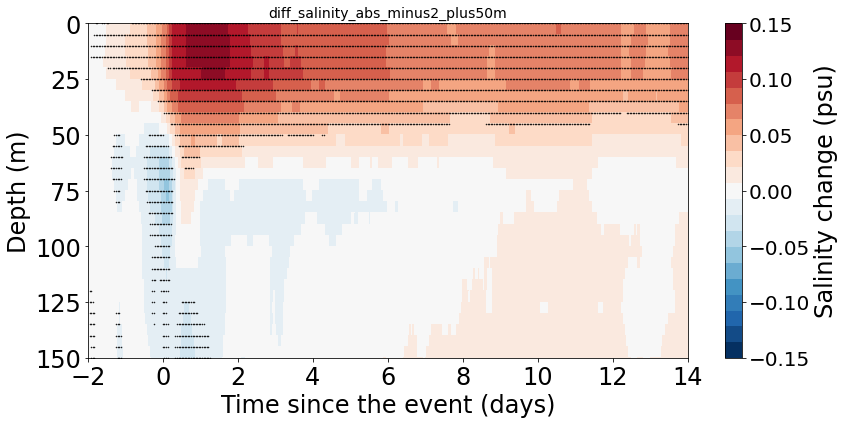

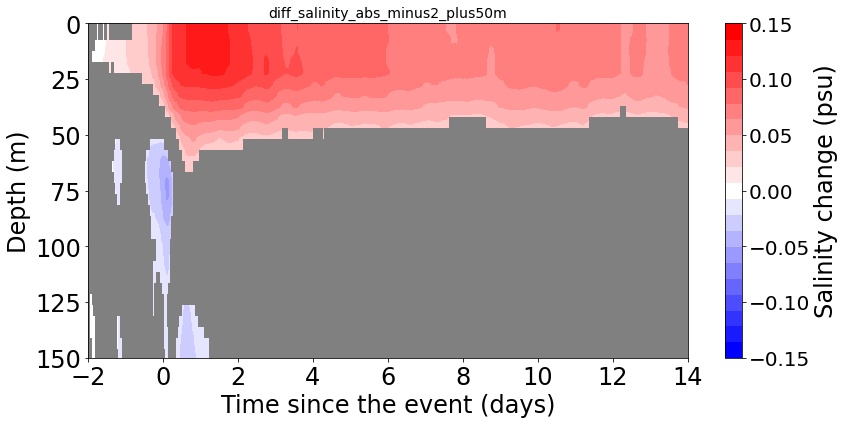

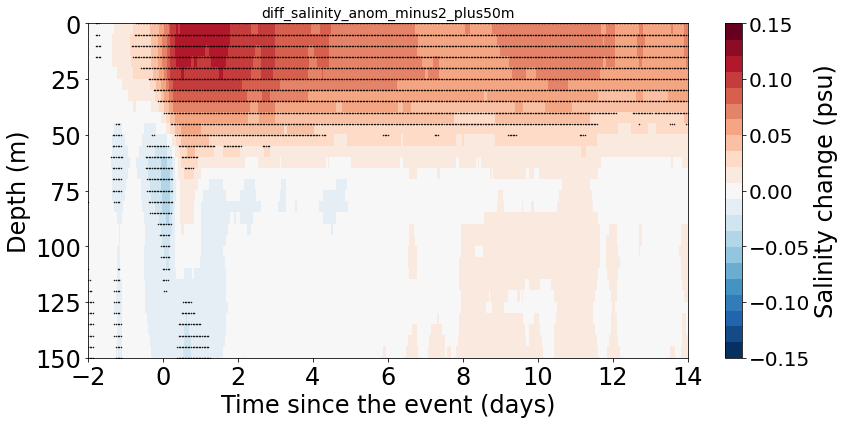

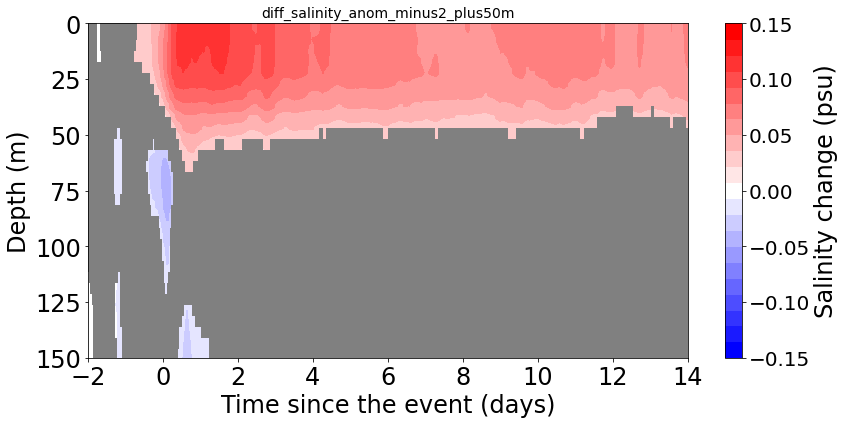

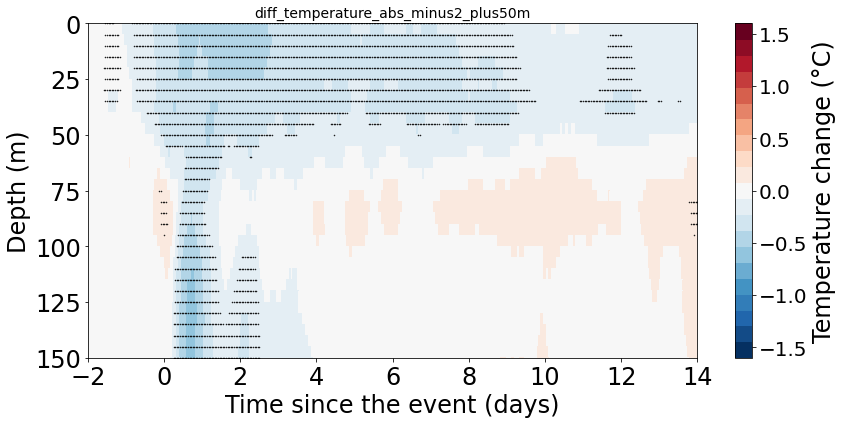

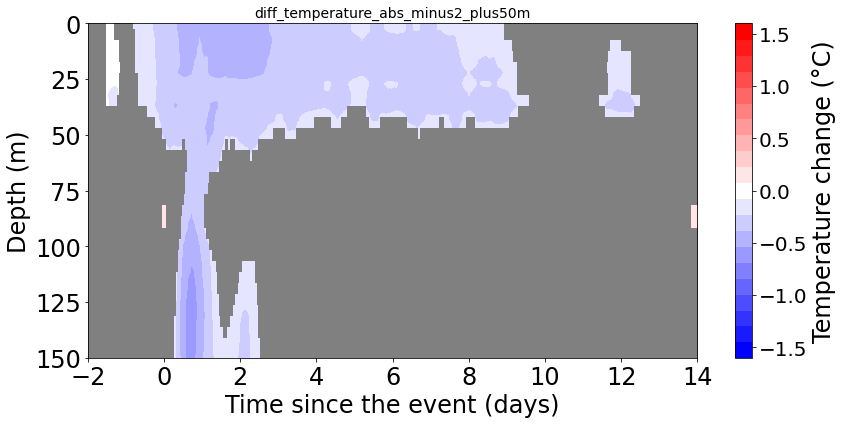

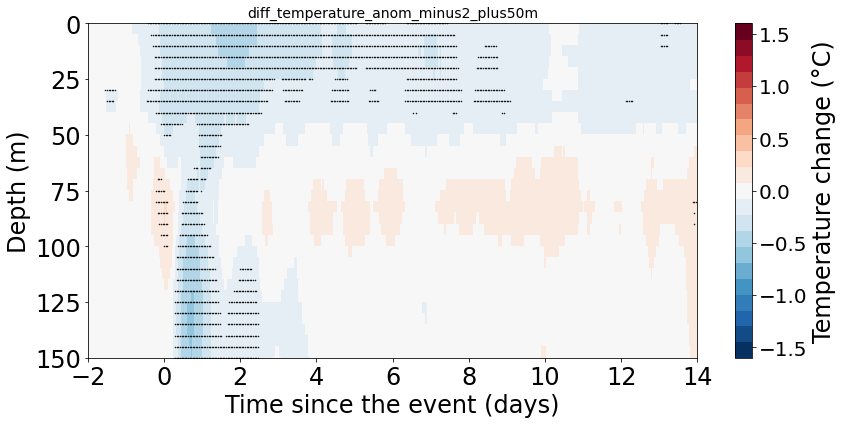

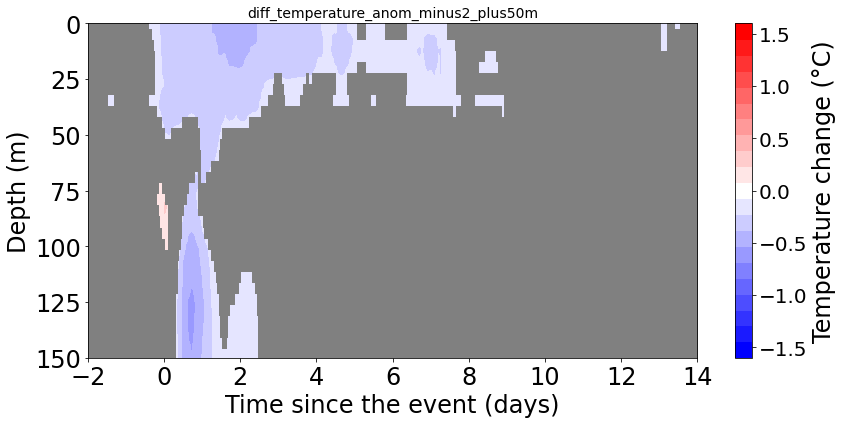

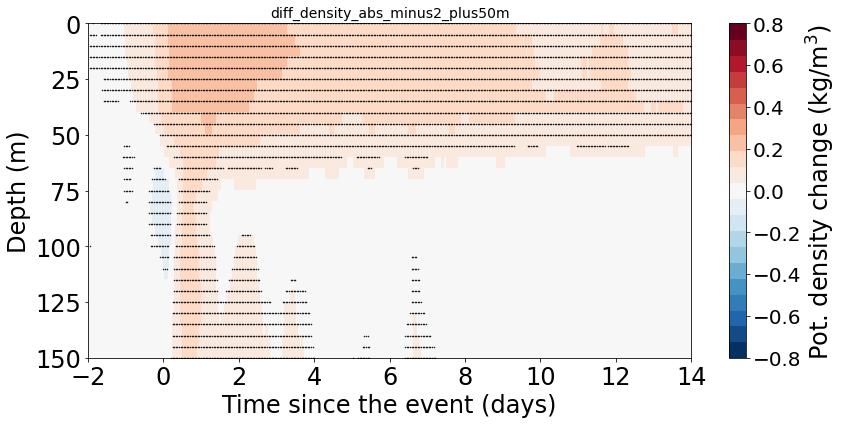

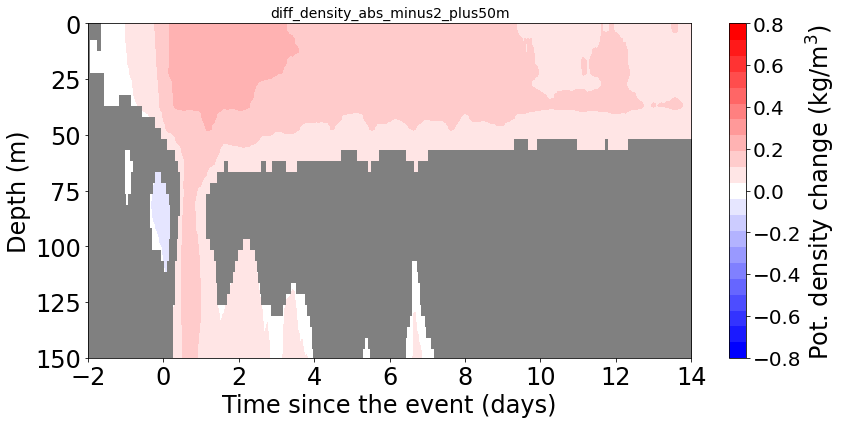

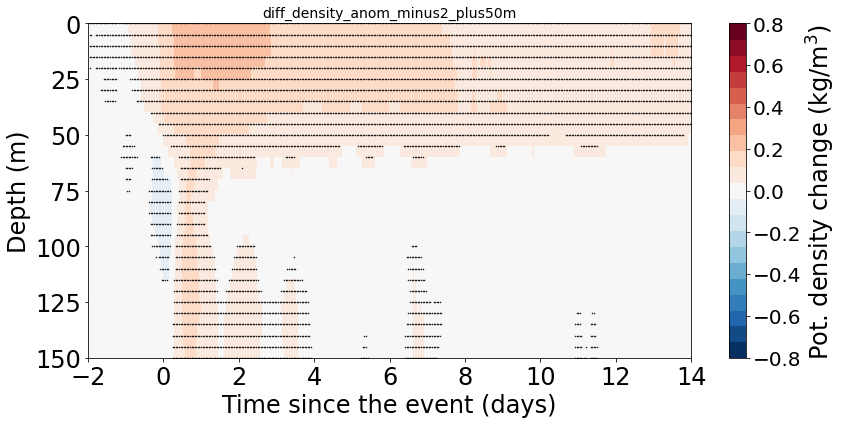

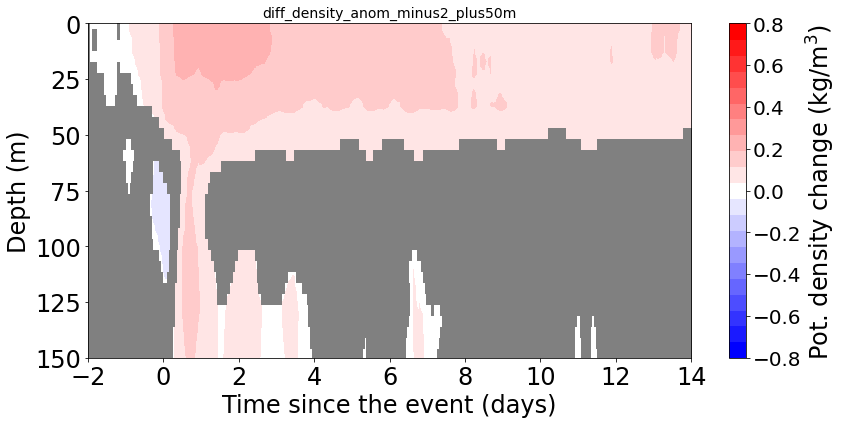

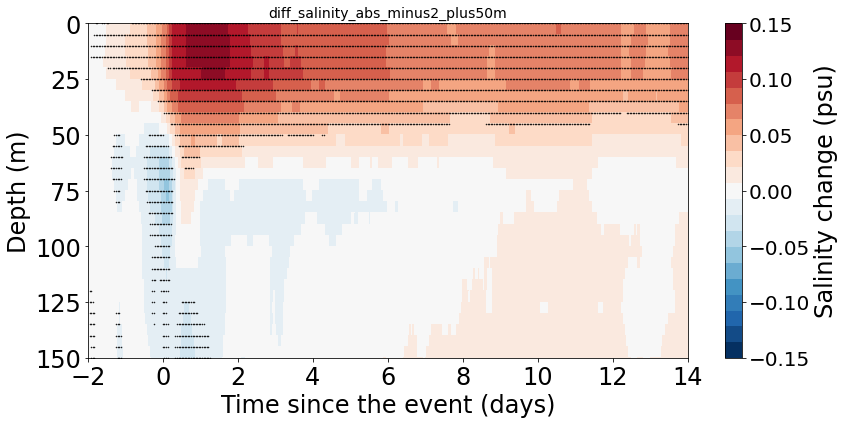

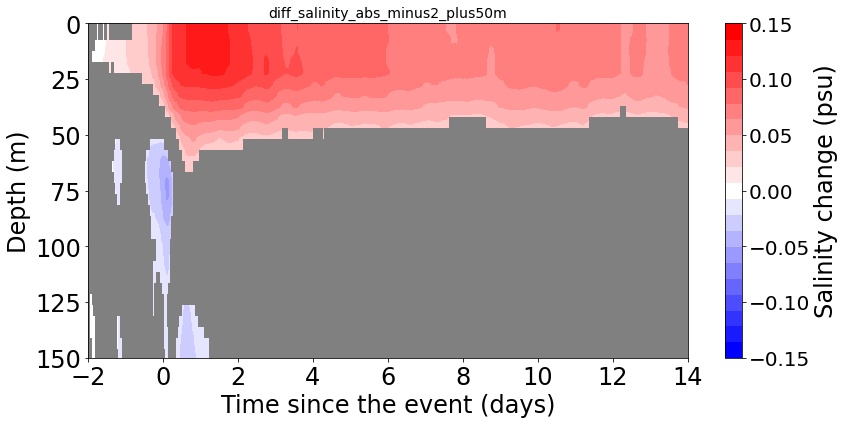

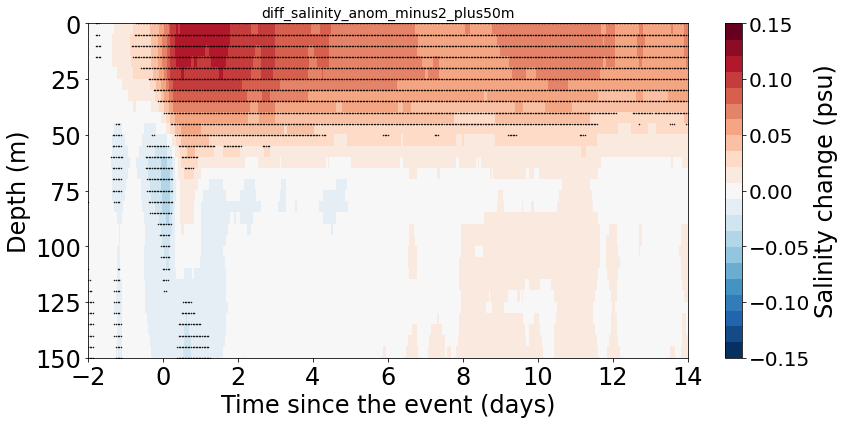

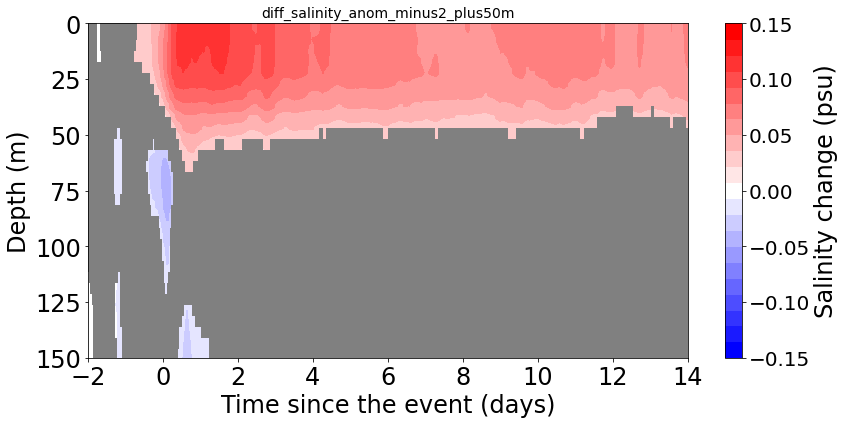

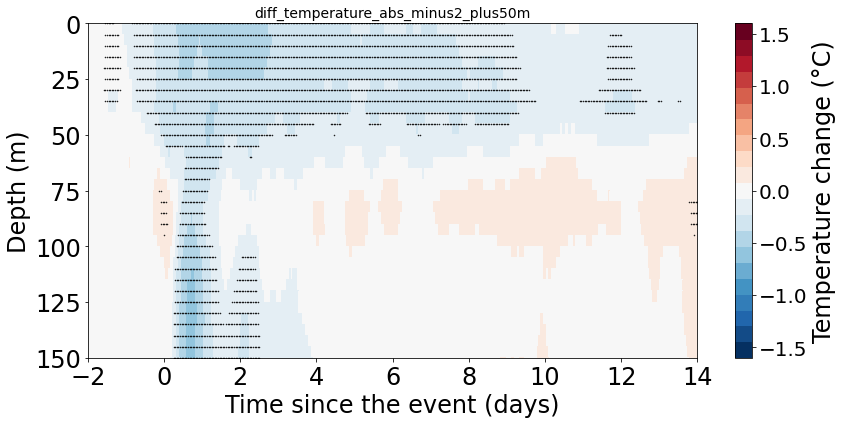

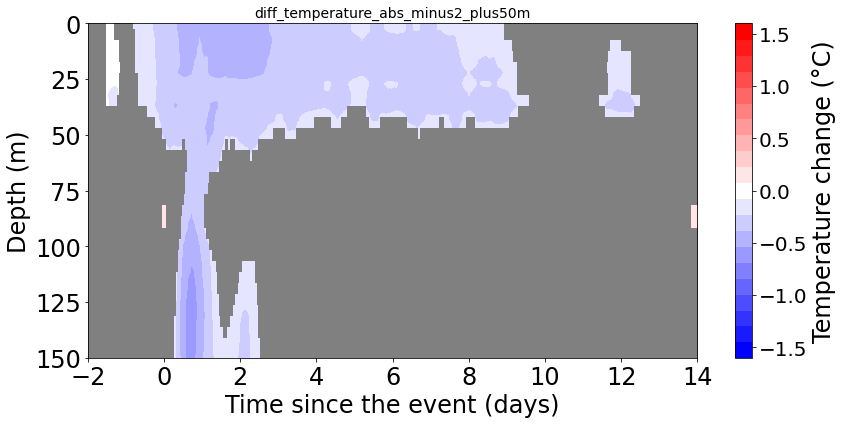

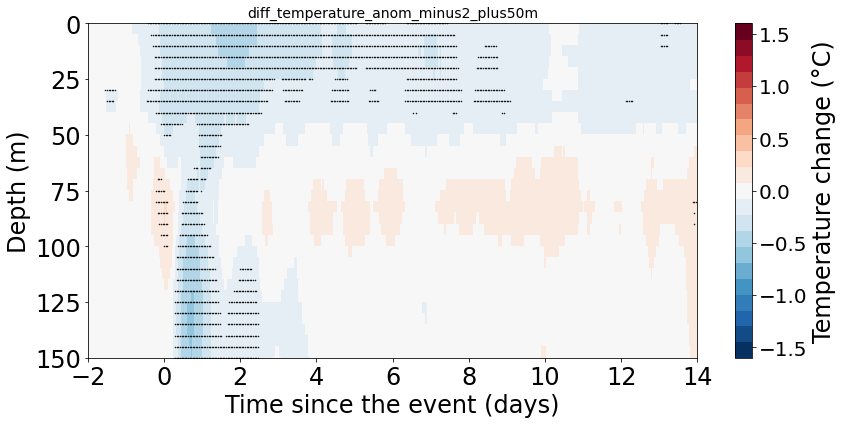

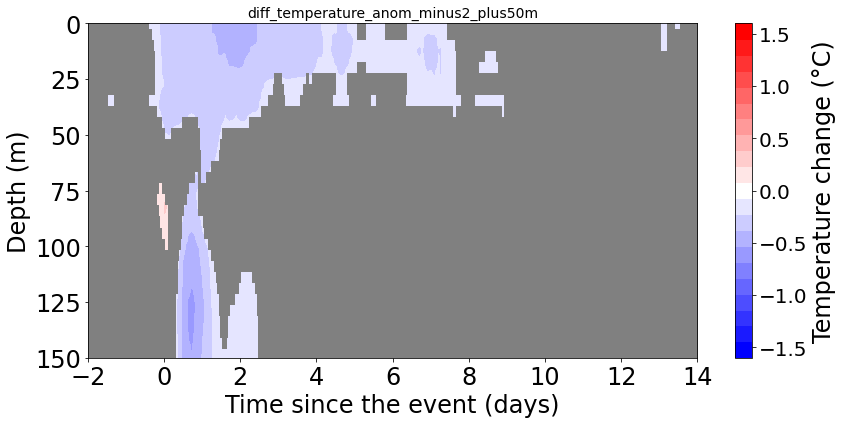

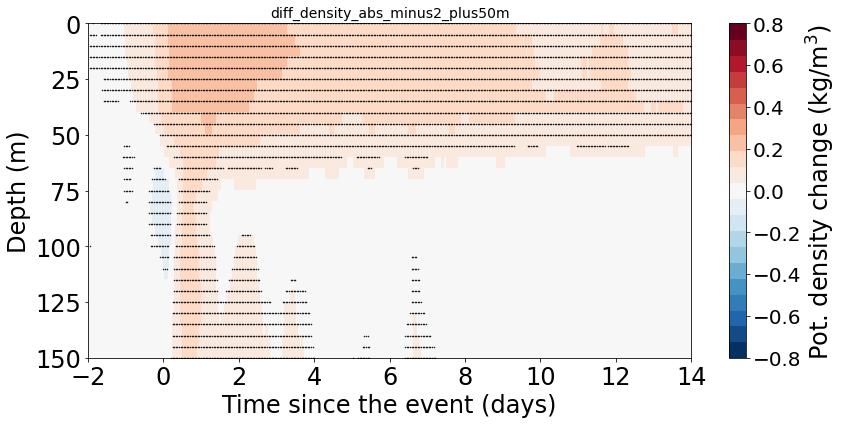

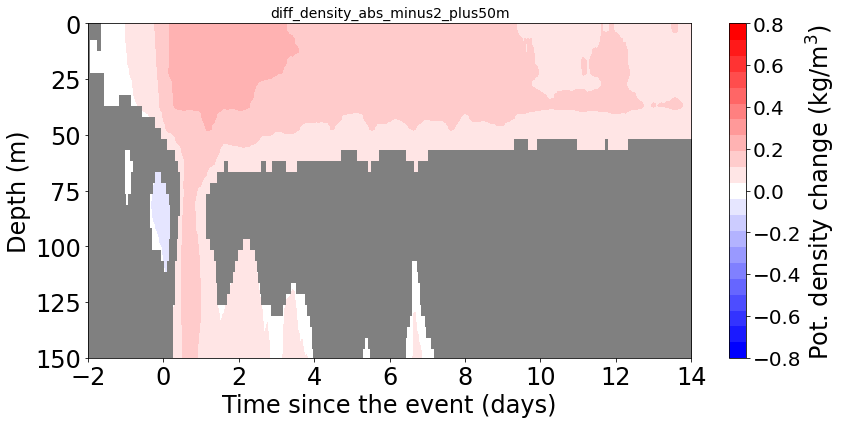

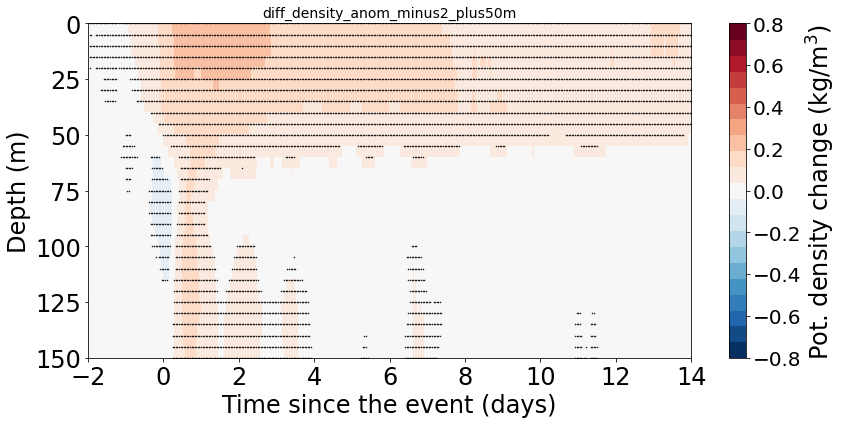

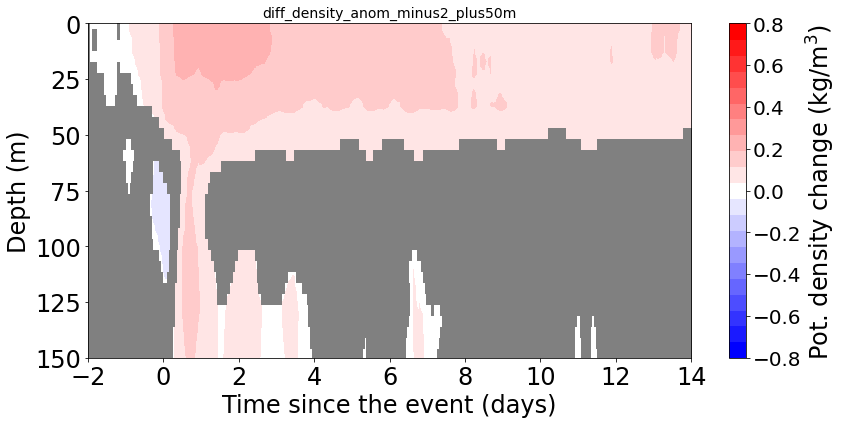

In [22]:
# Calculate differences (incr - decr) and make SINGLE PANEL plots

for icase in case_list:
    i = 0
    for ivar in np.arange(0,len(var_list),1):
        iunit = units_list[i]
        i = i + 1
        for itype in type_list:
            for ihatch in type_hatch_list: # std, std error
                if ihatch == '_std_error':
                    ihatch_factor = 1.96
                    ihatch_factor_tag = ' (95% confidence limit)'
                else:
                    ihatch_factor = 1 # change to 2 in the future
                    ihatch_factor_tag = ''   

                # Increasing vs decreasing for this mask and variable
                bfr_d_incr = eval(var_list[ivar] + '_' + itype + '_mask_incr')
                bfr_d_decr = eval(var_list[ivar] + '_' + itype + '_mask_decr')
                bfr_d_incr_ihatch = eval(var_list[ivar] + '_' + itype + '_mask_incr' + ihatch)
                bfr_d_decr_ihatch = eval(var_list[ivar] + '_' + itype + '_mask_decr' + ihatch)

                # Calculate differences
                bfr_d_diff = bfr_d_incr - bfr_d_decr
                # Calculate std error of the differences
                bfr_d_diff_ihatch = np.sqrt(np.square(bfr_d_incr_ihatch) + np.square(bfr_d_decr_ihatch))
    #                 bfr_d_diff_ihatch = bfr_d_incr_ihatch + bfr_d_decr_ihatch

                # Make difference plot
                function_single_panels_plots(data = bfr_d_diff, \
                               data_ihatch = ihatch_factor * bfr_d_diff_ihatch, \
                               data_tag = 'diff_' + var_list[ivar] + '_' + itype, \
                               ihatch_tag = ihatch, \
                               ihatch_tag_confidence_limit = ihatch_factor_tag, \
                               data_xaxis = time_plot,\
                               data_yaxis = combined_regions_interpolated.depth.values,\
                               data_yaxis_lim = [0, 150], \
                               data_vmin = set_clim_plots_diff(var_list[ivar], itype)[0], \
                               data_vmax = set_clim_plots_diff(var_list[ivar], itype)[1], \
                               std_vmin = set_clim_plots_std_diff(var_list[ivar], itype, ihatch)[0], \
                               std_vmax = set_clim_plots_std_diff(var_list[ivar], itype, ihatch)[1], \
                               cmap = set_cmap(itype),
                               units = iunit,
                               mask_tag = mask_tag)
                       
                # Make difference plot - grey shading
                function_single_panels_plots_grey_shading(data = bfr_d_diff, \
                               data_ihatch = ihatch_factor * bfr_d_diff_ihatch, \
                               data_tag = 'diff_' + var_list[ivar] + '_' + itype, \
                               ihatch_tag = ihatch, \
                               ihatch_tag_confidence_limit = ihatch_factor_tag, \
                               data_xaxis = time_plot,\
                               data_yaxis = combined_regions_interpolated.depth.values,\
                               data_yaxis_lim = [0, 150], \
                               data_vmin = set_clim_plots_diff(var_list[ivar], itype)[0], \
                               data_vmax = set_clim_plots_diff(var_list[ivar], itype)[1], \
                               std_vmin = set_clim_plots_std_diff(var_list[ivar], itype, ihatch)[0], \
                               std_vmax = set_clim_plots_std_diff(var_list[ivar], itype, ihatch)[1], \
                               cmap = set_cmap(itype),
                               units = iunit,
                               mask_tag = mask_tag)

In [ ]:
ciao

### SANITY CHECK - INCREASING - ALL EVENTS - time vs event index (RED - BLUE)


Plot showing, for a given vertical level (you could do it in a loop for the first 5 or something HYCOM level, i.e. using the actual levels without vertical interpolation to a finer vertical grid), the timeseries of anom_minus2… the plot will still be a scatter plot, yet the horizontal axis will be delta time, the vertical axis will be (original) index number, and the color is the value for anom_minus2. 

In [ ]:
# Define the number of subplots
num_subplots = 1

# Decide every how many time delta values to make the plot
stagger_time_delta = 10

# Define mask
mask = mask_incr  # Replace with your actual mask

# Define ilev_max
ilev_max = 10
for ilev in np.arange(0,ilev_max,1):
    
    # Variable to plot
    salinity_minus2 = combined_regions.salinity_anom_minus2.values[:, ::stagger_time_delta, ilev]

    # Express delta time in fraction of days
    delta_time_in_days = combined_regions.salinity_anom_minus2.delta_time / np.timedelta64(1, 'D')

    # Define the total number of events
    total_events = salinity_minus2.shape[0]
    total_delta_time = salinity_minus2.shape[1]

    # Set up the figure with subplots
    fig, ax = plt.subplots(num_subplots, 1, figsize=(15, 120))

    # Plot circles for each depth level in each event
    event_counter = 0  # Track the current event index

    for _ in range(total_events):
        # Check if the current event is masked
        if mask[event_counter]:
            # Plot profile for this event
            y_values = np.full(total_delta_time, event_counter)
            x_values = delta_time_in_days[::stagger_time_delta].values
            sizes = 40

            # Sort indices based on salinity_minus2 values for this event
    #         sorted_indices = np.argsort(salinity_minus2[event_counter, :])

            # Scatter plot with color based on sorted salinity_minus2 values
            sc = ax.scatter(x_values, y_values, s=sizes, c=salinity_minus2[event_counter, :], cmap='bwr', edgecolors='k', linewidth=0.5)

        # Increment event counter
        event_counter += 1

    plt.axvline(x = 0, color='red')

    # Set labels for each subplot
    ax.set_ylabel(f'Event Number', fontsize=18)

    # Add colorbar to the last subplot
    cbar = plt.colorbar(sc, ax=ax, label='Salinity anom (psu)')

    # Set labels and title for the whole figure
    ax.set_xlabel('Time Delta [days]', fontsize=18)
    fig.suptitle(f'Salinity anom_minus2 - increasing - mask {mask_tag} - lev {combined_regions.depth.values[ilev]}', fontsize=18)

    ax.set_ylim([0,total_events])

    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    save_fig_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/MASKS_SANITY_CHECK_PLOTS/'
    # Show the plot
    plt.savefig(f"{save_fig_path}/Salinity_anom_minus2_check_{mask_tag}_incr_all_events_time_vs_event_index_lev{combined_regions.depth.values[ilev]}.png", dpi=300)
    plt.show()
    
    
    

### SANITY CHECK - DECREASING - ALL EVENTS - time vs event index (RED - BLUE)


In [ ]:
# Define the number of subplots
num_subplots = 1

# Decide every how many time delta values to make the plot
stagger_time_delta = 10

# Define mask
mask = mask_decr  # Replace with your actual mask

# Define ilev_max
ilev_max = 10
for ilev in np.arange(0,ilev_max,1):
    
    # Variable to plot
    salinity_minus2 = combined_regions.salinity_anom_minus2.values[:, ::stagger_time_delta, ilev]

    # Express delta time in fraction of days
    delta_time_in_days = combined_regions.salinity_anom_minus2.delta_time / np.timedelta64(1, 'D')

    # Define the total number of events
    total_events = salinity_minus2.shape[0]
    total_delta_time = salinity_minus2.shape[1]

    # Set up the figure with subplots
    fig, ax = plt.subplots(num_subplots, 1, figsize=(15, 120))

    # Plot circles for each depth level in each event
    event_counter = 0  # Track the current event index

    for _ in range(total_events):
        # Check if the current event is masked
        if mask[event_counter]:
            # Plot profile for this event
            y_values = np.full(total_delta_time, event_counter)
            x_values = delta_time_in_days[::stagger_time_delta].values
            sizes = 40

            # Sort indices based on salinity_minus2 values for this event
    #         sorted_indices = np.argsort(salinity_minus2[event_counter, :])

            # Scatter plot with color based on sorted salinity_minus2 values
            sc = ax.scatter(x_values, y_values, s=sizes, c=salinity_minus2[event_counter, :], cmap='bwr', edgecolors='k', linewidth=0.5)

        # Increment event counter
        event_counter += 1

    plt.axvline(x = 0, color='red')

    # Set labels for each subplot
    ax.set_ylabel(f'Event Number', fontsize=18)

    # Add colorbar to the last subplot
    cbar = plt.colorbar(sc, ax=ax, label='Salinity anom (psu)')

    # Set labels and title for the whole figure
    ax.set_xlabel('Time Delta [days]', fontsize=18)
    fig.suptitle(f'Salinity anom_minus2 - decreasing - mask {mask_tag} - lev {combined_regions.depth.values[ilev]}', fontsize=18)

    ax.set_ylim([0,total_events])

    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    save_fig_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/MASKS_SANITY_CHECK_PLOTS/'
    # Show the plot
    plt.savefig(f"{save_fig_path}/Salinity_anom_minus2_check_{mask_tag}_decr_all_events_time_vs_event_index_lev{combined_regions.depth.values[ilev]}.png", dpi=300)
    plt.show()
    
    
    

In [ ]:
# # SANITY CHECK - INCREASING - old version plotting only points where inc mask was true

# salinity_minus2 = combined_regions.salinity_abs.values[mask_incr, i_time, :]

# # Calculate min and max % difference from top layer for colorbar limits
# min_diff_pct = np.nanmin((salinity_minus2 - salinity_minus2[:, 0:1]) / salinity_minus2[:, 0:1] * 100, axis=1)
# max_diff_pct = np.nanmax((salinity_minus2 - salinity_minus2[:, 0:1]) / salinity_minus2[:, 0:1] * 100, axis=1)

# events, depth = salinity_minus2.shape

# # Specify the number of subplots (rows)
# num_subplots = 5

# # Calculate the number of events to display in each subplot
# events_per_subplot = len(salinity_minus2) // num_subplots

# # Set up the figure with subplots
# fig, axs = plt.subplots(num_subplots, 1, figsize=(20, 20), sharex=False)

# # Invert the y-axis for all subplots
# for ax in axs:
#     ax.invert_yaxis()

# # Plot circles for each depth level in each event
# for j, ax in enumerate(axs):
#     start_event = j * events_per_subplot
#     end_event = (j + 1) * events_per_subplot if j < num_subplots - 1 else len(salinity_minus2)

#     # Plotting circles for each depth level in each event
#     for i in range(start_event, end_event):
#         x_values = np.full(depth, i)
#         y_values = np.arange(depth)
#         sizes = 50  # size of the circles

#         # Sort indices based on salinity_minus2 values
#         sorted_indices = np.argsort(salinity_minus2[i, :])

#         # Scatter plot with color based on sorted salinity_minus2 values
#         sc = ax.scatter(x_values, y_values, s=sizes, c=sorted_indices, cmap='viridis', edgecolors='k')

#     # Set labels for each subplot
#     ax.set_ylabel(f'Depth Index (Subplot {j + 1})', fontsize=18)

# # Add colorbar to the last subplot
# cbar = plt.colorbar(sc, ax=axs[-1], label='Sorted Salinity Index')

# # Set labels and title for the whole figure
# axs[-1].set_xlabel('Event Number', fontsize=18)
# fig.suptitle(f'Sorted Salinity Index (Divided Among 4 Subplots) - increasing - mask {mask_tag}', fontsize=18)

# # Adjust layout
# plt.tight_layout(rect=[0, 0, 1, 0.96])

# save_fig_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/MASKS_SANITY_CHECK_PLOTS/'
# # Show the plot
# plt.savefig(f"{save_fig_path}/Sanity_check_{mask_tag}_incr.png", dpi = 300)
# plt.show()


In [ ]:
# # SANITY CHECK - DECREASING old version plotting only points where dec mask was true

# salinity_minus2 = combined_regions.salinity_abs.values[mask_decr, i_time, :]

# # Calculate min and max % difference from top layer for colorbar limits
# min_diff_pct = np.nanmin((salinity_minus2 - salinity_minus2[:, 0:1]) / salinity_minus2[:, 0:1] * 100, axis=1)
# max_diff_pct = np.nanmax((salinity_minus2 - salinity_minus2[:, 0:1]) / salinity_minus2[:, 0:1] * 100, axis=1)

# events, depth = salinity_minus2.shape

# # Specify the number of subplots (rows)
# num_subplots = 2

# # Calculate the number of events to display in each subplot
# events_per_subplot = len(salinity_minus2) // num_subplots

# # Set up the figure with subplots
# fig, axs = plt.subplots(num_subplots, 1, figsize=(20, 10), sharex=False)

# # Invert the y-axis for all subplots
# for ax in axs:
#     ax.invert_yaxis()

# # Plot circles for each depth level in each event
# for j, ax in enumerate(axs):
#     start_event = j * events_per_subplot
#     end_event = (j + 1) * events_per_subplot if j < num_subplots - 1 else len(salinity_minus2)

#     # Plotting circles for each depth level in each event
#     for i in range(start_event, end_event):
#         x_values = np.full(depth, i)
#         y_values = np.arange(depth)
#         sizes = 50  # size of the circles

#         # Sort indices based on salinity_minus2 values
#         sorted_indices = np.argsort(salinity_minus2[i, :])

#         # Scatter plot with color based on sorted salinity_minus2 values
#         sc = ax.scatter(x_values, y_values, s=sizes, c=sorted_indices, cmap='viridis', edgecolors='k')

#     # Set labels for each subplot
#     ax.set_ylabel(f'Depth Index (Subplot {j + 1})', fontsize=18)

# # Add colorbar to the last subplot
# cbar = plt.colorbar(sc, ax=axs[-1], label='Sorted Salinity Index')

# # Set labels and title for the whole figure
# axs[-1].set_xlabel('Event Number', fontsize=18)
# fig.suptitle(f'Sorted Salinity Index (Divided Among 4 Subplots) - decreasing - mask {mask_tag}', fontsize=18)

# # Adjust layout
# plt.tight_layout(rect=[0, 0, 1, 0.96])

# save_fig_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/MASKS_SANITY_CHECK_PLOTS/'
# # Show the plot
# plt.savefig(f"{save_fig_path}/Sanity_check_{mask_tag}_decr.png", dpi = 300)
# plt.show()
